**Imports**

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm,beta,binom
import pandas as pd
from scipy.optimize import minimize
from matplotlib.ticker import AutoMinorLocator

colors = ['crimson','midnightblue', 'violet','orange','springgreen','dodgerblue','darkviolet', 'olive','tomato']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

**Exercise 1**

In [26]:
def prior(x,alpha=5,beta_=17):
    return beta.pdf(x, a=alpha,b=beta_) # Use SciPy's own gamma PDF

def likelihood(n,k,p): # Prior having integrated and found N = 2.93
    return binom.pmf(k, n, p)

def posterior(x,alpha,beta_,n,k):
    return prior(x,alpha,beta_)*likelihood(n,k,x)

In [27]:
x_space = np.linspace(0,1,1000) # Generate x-values from 0 < x < 4

Likeli , Prio , Prob = [] , [] , [] # Empty lists

for i in x_space: # Loop across x-values
    Likeli.append(likelihood(n=100,k=66,p=i))
    Prio.append(prior(i,alpha=5,beta_=17))
    Prob.append(posterior(i,alpha=5,beta_=17,n=100,k=66))

In [28]:
Likeli_integral = np.trapz(Likeli,x_space) # Get the integrals to ensure normalization
Posterior_integral = np.trapz(Prob,x_space)

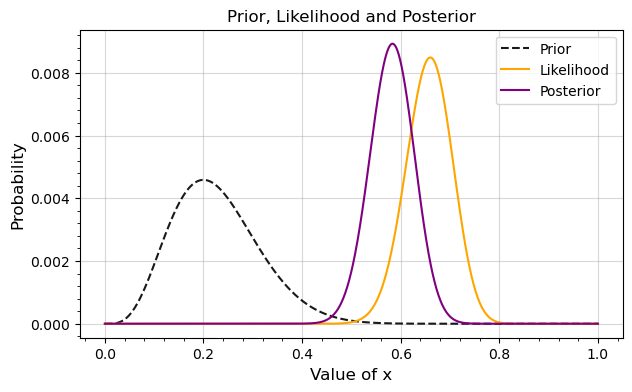

In [29]:
plt.figure(figsize=(7,4))

plt.plot(x_space,Prio / np.sum(Prio),alpha=.9,linestyle='--',color='k',label='Prior')
plt.plot(x_space,Likeli / np.sum(Likeli),alpha=1.,linestyle='-',color='orange',label='Likelihood')
plt.plot(x_space,Prob / np.sum(Prob),alpha=1.,linestyle='-',color='purple',label='Posterior')

ax = plt.gca() # For setting sub-ticks
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='minor', length=2, color='k')

plt.title('Prior, Likelihood and Posterior',fontsize=12)
plt.xlabel('Value of x',fontsize=12)
plt.ylabel('Probability',fontsize=12)
plt.grid(True,alpha=0.5,zorder=-10)
ax.set_axisbelow(True)
#plt.ylim(0,1.)
#plt.xlim(0,4)
plt.legend()
plt.show()

**Exercise 2**

In [30]:
def move_markov(value,steps):
    
    list_of_values = []
    
    for i in range(steps):
        value = np.random.normal(0.5*value,1, size=1)
        list_of_values.append(value)
        
    return list_of_values

In [31]:
cycles = 1000

Set_1 = move_markov(100,cycles)
Set_2 = move_markov(-27,cycles)

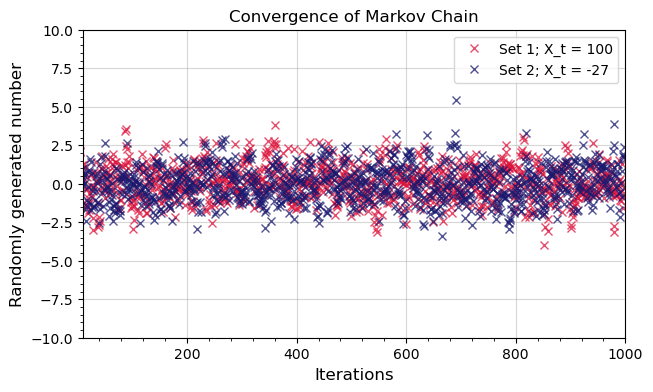

In [32]:
plt.figure(figsize=(7,4))

plt.plot(range(cycles),Set_1,alpha=.75,label='Set 1; X_t = 100',linestyle='',marker='x')
plt.plot(range(cycles),Set_2,alpha=.75,label='Set 2; X_t = -27',linestyle='',marker='x')

ax = plt.gca() # For setting sub-ticks
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='minor', length=2, color='k')

plt.title('Convergence of Markov Chain',fontsize=12)
plt.xlabel('Iterations',fontsize=12)
plt.ylabel('Randomly generated number',fontsize=12)
plt.grid(True,alpha=0.5,zorder=-10)
ax.set_axisbelow(True)
plt.xlim(10,cycles)
plt.ylim(-10,10)
plt.legend()
plt.show()

In [33]:
print(f'The mean of set 1 is {np.mean(Set_1[10:]):.3}, and its standard deviation is {np.std(Set_1[10:]):.3}')
print(f'The mean of set 2 is {np.mean(Set_2[10:]):.3}, and its standard deviation is {np.std(Set_2[10:]):.3}')

The mean of set 1 is 0.0856, and its standard deviation is 1.15
The mean of set 2 is -0.00275, and its standard deviation is 1.18


**Exercise 3**

In [45]:
def prior(x,alpha=5,beta_=17):
    return beta.pdf(x, a=alpha,b=beta_) # Use SciPy's own gamma PDF

def likelihood(n,k,p): # Prior having integrated and found N = 2.93
    return binom.pmf(k, n, p)

def posterior(x):
    return prior(x,alpha=5,beta_=17)*likelihood(n=100,k=66,p=x)


def proposal_pdf(x):
    return np.random.normal(0+x,0.3,size=1)

def acceptance_ratio(x,x_new,target):
    r = target(x_new) / target(x)
    return r

In [35]:
value = 0.5
N = 0

samples = []

cycles = 10000

for i in range(cycles):
    new_value = proposal_pdf(value)
    if isinstance(new_value, np.ndarray):
        new_value = new_value.item()
    if new_value < 1 and new_value > 0:
        r_value = acceptance_ratio(value,new_value,posterior)
        
        if r_value >= 1:
            value = new_value
            
        elif r_value < 1:
            random_number = np.random.uniform(0,1)
            if r_value > random_number:
                value = new_value
            else:
                N += 1
                samples.append(value)

Text(0, 0.5, '$Density$')

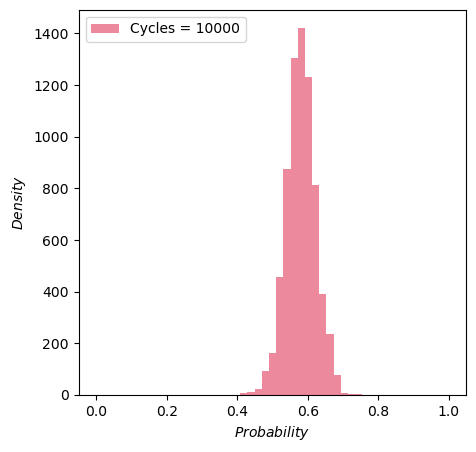

In [38]:
plt.figure(figsize = (5,5))

plt.hist(samples,bins=np.linspace(0,1,50),density=False,alpha=0.5,label = f'Cycles = {cycles}')

plt.legend(loc = 'upper left',frameon = True)
plt.xlabel('$Probability$')
plt.ylabel('$Density$')

**Exercise 4**

In [58]:
import numpy as np
import emcee
import scipy.stats as stats

# Define the prior
def log_prior(x):
    if 0 < x < 1:
        return stats.beta.logpdf(x, a=5, b=17)  # Use your alpha and beta values
    else:
        return -np.inf  # Makes the probability zero outside [0, 1]


# Define the likelihood
def log_likelihood(x, n=100, k=66):
    return stats.binom.logpmf(k, n, x)

def log_posterior(x):
    lp = log_prior(x[0])
    if np.isnan(lp):
        print(f"NaN detected in log_prior for x={x}")
        return -np.inf  # Return a large negative value to indicate invalidity
    ll = log_likelihood(x[0])
    if np.isnan(ll):
        print(f"NaN detected in log_likelihood for x={x}")
        return -np.inf
    return lp + ll
# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers=50, ndim=1, log_prob_fn=log_posterior)

# Choose an initial state for each walker
np.random.seed(42)
initial = np.random.rand(50, 1)

# Number of MCMC steps to take
nsteps = 100

# Perform the sampling
sampler.run_mcmc(initial, nsteps, progress=True)

# Get the flat chain of samples after burn-in
# Assuming the first 1000 steps are "burn-in"
samples_emcee = sampler.get_chain(discard=0, flat=True)

  2%|▏         | 2/100 [00:00<00:05, 17.52it/s]

NaN detected in log_likelihood for x=[-0.03881671]
NaN detected in log_likelihood for x=[-0.15640554]
NaN detected in log_likelihood for x=[1.28306311]
NaN detected in log_likelihood for x=[1.50038623]
NaN detected in log_likelihood for x=[1.12243502]
NaN detected in log_likelihood for x=[1.28251274]
NaN detected in log_likelihood for x=[1.28815983]
NaN detected in log_likelihood for x=[1.47163163]
NaN detected in log_likelihood for x=[-0.05506302]
NaN detected in log_likelihood for x=[-0.21934788]
NaN detected in log_likelihood for x=[-0.05910655]
NaN detected in log_likelihood for x=[-0.58760882]
NaN detected in log_likelihood for x=[1.26363726]
NaN detected in log_likelihood for x=[-0.16373712]
NaN detected in log_likelihood for x=[1.30131895]
NaN detected in log_likelihood for x=[-0.50792537]
NaN detected in log_likelihood for x=[-0.31069016]
NaN detected in log_likelihood for x=[-0.16752376]
NaN detected in log_likelihood for x=[1.14617954]
NaN detected in log_likelihood for x=[-0

  8%|▊         | 8/100 [00:00<00:04, 20.72it/s]

NaN detected in log_likelihood for x=[-0.05642463]
NaN detected in log_likelihood for x=[-0.19991969]
NaN detected in log_likelihood for x=[1.10959509]
NaN detected in log_likelihood for x=[-0.33682166]
NaN detected in log_likelihood for x=[1.01359562]
NaN detected in log_likelihood for x=[-0.10406807]
NaN detected in log_likelihood for x=[1.01585243]
NaN detected in log_likelihood for x=[-0.01161544]
NaN detected in log_likelihood for x=[-0.16688477]
NaN detected in log_likelihood for x=[-0.26089388]
NaN detected in log_likelihood for x=[-0.02305054]


 11%|█         | 11/100 [00:00<00:04, 17.80it/s]

NaN detected in log_likelihood for x=[-0.08190866]
NaN detected in log_likelihood for x=[1.1120798]
NaN detected in log_likelihood for x=[1.19448811]
NaN detected in log_likelihood for x=[-0.11309873]
NaN detected in log_likelihood for x=[-0.03465932]


100%|██████████| 100/100 [00:05<00:00, 18.95it/s]


Text(0, 0.5, '$Density$')

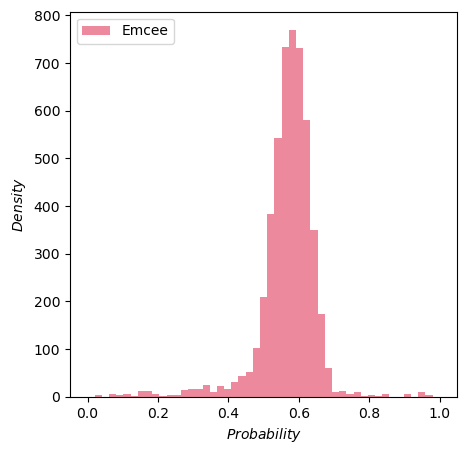

In [59]:
plt.figure(figsize = (5,5))

plt.hist(samples_emcee,bins=np.linspace(0,1,50),density=False,alpha=0.5,label = f'Emcee')

plt.legend(loc = 'upper left',frameon = True)
plt.xlabel('$Probability$')
plt.ylabel('$Density$')